**Tutorial 5 - Measuring a Spectral Line by Bayesian Parameter Estimation**

In this tutorial you will measure the strength and width of a spectral line 
using a Bayesian method.


1) Read in the data from the file tut_05_data.csv.  There are three 
columns: wavelength, flux and sigma.  Sigma is the known standard deviation 
of the flux in each pixel.  Plot the spectrum using matplotlib.pyplot.errorbar().

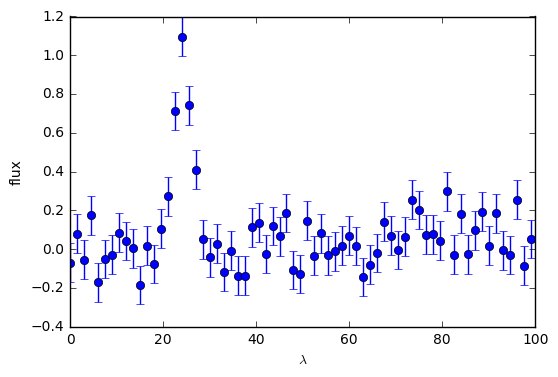

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pa

df = pa.read_csv('C:\\Users\\utente\\Desktop\\tut_05_data.csv')
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
plt.xlabel(r'$\lambda$')
plt.ylabel('flux')
plt.show()

2) First we need to subtract off the continuum. We know that there is a line centered around $\lambda \simeq 23$.  Take the part of the spectrum with $\lambda > 45$ which should just be background.  Assuming the noise is Gaussian and uncorrelated.   Using a uniform prior on the background.

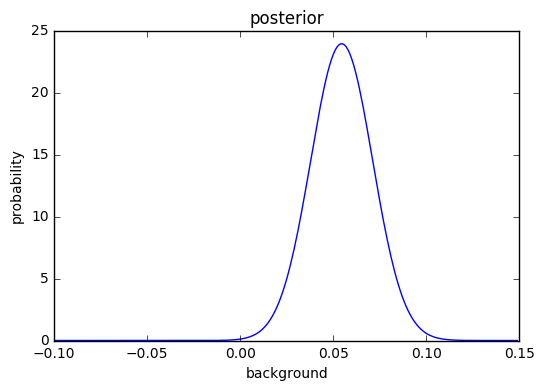

Posterior at edges of parameter space:  5.14587371878e-18 2.52702008593e-06
Optimization terminated successfully.
         Current function value: 22.314737
         Iterations: 16
         Function evaluations: 32
The maximum likelihood background is : [ 0.0545]
The average of posterior  : 0.0545310867814
The variance of posterior  : 0.0166666649877


In [2]:

import scipy.optimize as opt

## filter out the background dominated region of the spectrum
f = df['flux'][ df['wavelength'] > 45 ]
l = df['wavelength'][ df['wavelength'] > 45 ]
s = df['sigma'][ df['wavelength'] > 45 ]

#plt.plot(l,f)
#plt.show()

## make a log-likelihood function assuming the noise Gaussian and 
## the pixels are independent
def loglike(b):
    return -0.5*np.sum( ( (f - b)/s )**2  )   ## this is chi^2

## Make an array of possible background values.
## To find the right range it is sometimes useful to 
## plot the log-likelihood over different ranges until 
## you find the maximum.
db = 0.001 ## resolution in background
background = np.arange(-0.1,0.15,db)

## calculate the likelihood at each of these background values
likelihood = np.empty(len(background))
for i,b in enumerate(background) :
    likelihood[i] = np.exp( loglike(b) )

## normalize to get the posterior
## You should look at the plot and make sure that
## the sum is a good approximation of the integral.
posterior = likelihood/np.sum(likelihood)/db
    
## plot posterior for background
plt.plot(background,posterior)
plt.xlabel('background')
plt.ylabel('probability')
plt.title('posterior')

plt.show()

print('Posterior at edges of parameter space: ',posterior[0],posterior[-1])

## find maximum of posterior and the variance
bmax = opt.fmin(lambda x: -loglike(x),0)
print('The maximum likelihood background is :',bmax)
bave = np.sum(posterior*background)*db
variance = np.sum(posterior*(background-bave)**2)*db
print('The average of posterior  :',bave)
print('The variance of posterior  :',np.sqrt(variance))


3) Now lets fit the line.  Assume the line has the profile

$ f(\lambda) = A \exp\left[- \left( \frac{(\lambda - \lambda_o)}{\Delta\lambda }\right)^2 \right] $

We want to find the parameters $A$, $\lambda_o$, $\Delta\lambda$ and the background.  

Write a function for the line profile.  

Write a function that returns the log-likelihood for the data with this model. 

Find the maximum likelihood values for the parameters using the whole data set.  Use the library function scipy.optimize.minimize() to do this.  Read the documentation for this function before starting.  You will need to make a guess to start the minimization.  Make these guesses from the plot of the data.

Draw the best fit model over the data.

      fun: 37.65762807188157
 hess_inv: array([[  6.96164492e-03,  -3.29195340e-04,  -1.11921048e-02,
         -1.19549290e-04],
       [ -3.29195340e-04,   2.98404942e-02,   1.66947978e-03,
         -1.27967118e-05],
       [ -1.11921048e-02,   1.66947978e-03,   6.08313972e-02,
         -5.87014964e-04],
       [ -1.19549290e-04,  -1.27967118e-05,  -5.87014964e-04,
          1.66320741e-04]])
      jac: array([  0.00000000e+00,  -4.76837158e-07,  -4.76837158e-07,
        -1.43051147e-06])
  message: 'Optimization terminated successfully.'
     nfev: 84
      nit: 10
     njev: 14
   status: 0
  success: True
        x: array([  1.02866769,  24.11716854,   2.61398132,   0.0286165 ])
[  1.02866769  24.11716854   2.61398132   0.0286165 ]


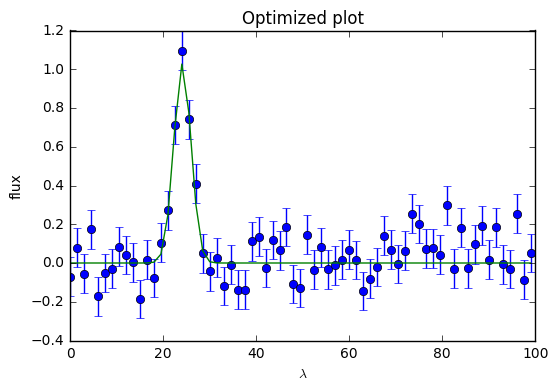

In [3]:
#def loglike(A,lo,dl,b):

f = df['flux']
l = df['wavelength']
s = df['sigma']

def line(A,l0,dl) : 
    return A*np.exp(-((l-l0)/dl)**2)

def negloglike(p):
    return 0.5*np.sum(((f - line(p[0],p[1],p[2])- p[3])/s)**2)

background = 0.06
lo = 24.
deltal = 3.
a = 1.

guess = np.array([a,lo,deltal,background])

def likelihood(p) : 
    return np.exp(-negloglike(p))

maxlike = opt.minimize(negloglike,guess)
print(maxlike)

maxpar = maxlike.x
print(maxpar)

    
plt.errorbar(df['wavelength'],df['flux'], yerr=df['sigma'],fmt='o')
maxf = line(maxpar[0],maxpar[1],maxpar[2])
plt.plot(l,maxf)
plt.xlabel('$\lambda$')
plt.ylabel('flux')
plt.title('Optimized plot')
plt.show()
             




4) Set all the parameters to their maximum likelihood values except the line strength $A$.  Make a plot of the posterior for $A$ near its maximum likelihood value with uniform and Jaffreys priors on $A$.

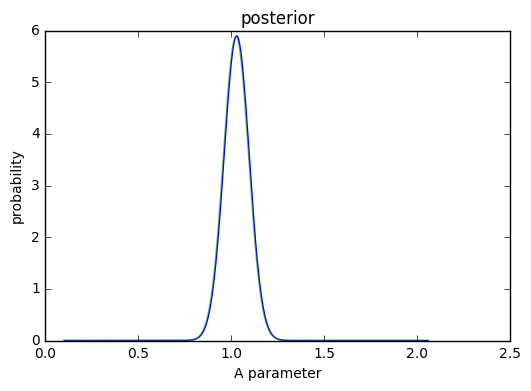

In [4]:
maxl0 = maxpar[1]
maxdl = maxpar[2]
maxb = maxpar[3]

da = 0.001 ## resolution in background
a = np.arange(0.1,2*maxpar[0],da)

likelihoodvec = np.empty(len(a))

for i in range(len(a)) :
    par = np.array([a[i],maxl0,maxdl,maxb])
    likelihoodvec[i] = likelihood(par)

posterior = likelihoodvec/np.sum(likelihoodvec)/da

plt.plot(a,posterior)
plt.xlabel('A parameter')
plt.ylabel('probability')
plt.title('posterior')

likelihoodj = np.empty(len(a))

for i in range(len(a)) :
    par = np.array([a[i],maxl0,maxdl,maxb])
    likelihoodj[i] = likelihood(par)/a[i] 

posteriorj = likelihoodj/np.sum(likelihoodj)/da

plt.plot(a,posteriorj,color = 'green',alpha = 0.5)
plt.show()


5) Make a 2D map of the posterior as a function of $A$ and $\Delta \lambda$ at the maximum likelihood values of the other parameters.  Do this by making a grid of $A$ and $\Delta \lambda$ values and using matplotlib.pyplot.contour().  Put the proper labels on the axes.

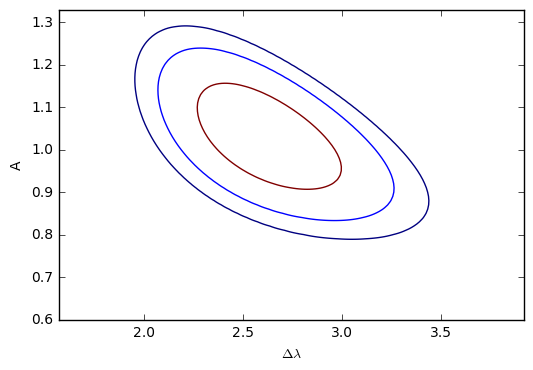

In [5]:
#####
def find_level(posterior,fraction) : 
    tot = np.sum(posterior)
    max = np.max(posterior)
    min = np.min(posterior)
    
    level = 0.5*(max+min)
    frac = np.sum(posterior[posterior >= level])/tot
    res = np.min(posterior[posterior >= level])/tot
    
    while(abs(frac-fraction)>res) : 
        if(frac > fraction) : 
            min = level
        else : 
            max = level
        level = 0.5*(max+min)
        frac = np.sum(posterior[posterior >= level])/tot
        res = np.min(posterior[posterior >= level])/tot
        
    return level, frac 
        
        
maxl0 = maxpar[1]
maxb = maxpar[3]

da = 0.01 
a = np.arange(0.6,1.3*maxpar[0],da)

ddl = 1./len(a)
deltal = np.arange(0.6*maxpar[2],1.5*maxpar[2],ddl)

X,Y = np.meshgrid(deltal,a)

like_mat = np.empty([len(a),len(deltal)])

for i in range(len(a)) : 
    for j in range(len(deltal)) : 
        par = [a[i], maxl0, deltal[j], maxb]
        like_mat[i, j] = likelihood(par)
        
post_mat = like_mat/np.sum(like_mat)/da
        
lev68 = find_level(post_mat,0.68)[0]
lev95 = find_level(post_mat,0.95)[0]
lev99 = find_level(post_mat,0.99)[0]

levels = (lev99, lev95, lev68)
plt.contour(X,Y,post_mat, levels)
plt.xlabel('$\Delta\lambda$')
plt.ylabel('A')
plt.show()


6) Write a function that takes values for $A$ and $\Delta \lambda$ and returns the 
posterior marginalizes over $\lambda_o$.  Use scipy.integrate.quad() to do the 
integration.  You will need to make a new "posterior" function with the correct 
order of input parameters to use this function.  Use the maximum likelihood value for the background from part 2).  You might want to reduce the resolution of the grid to reduce the run time.

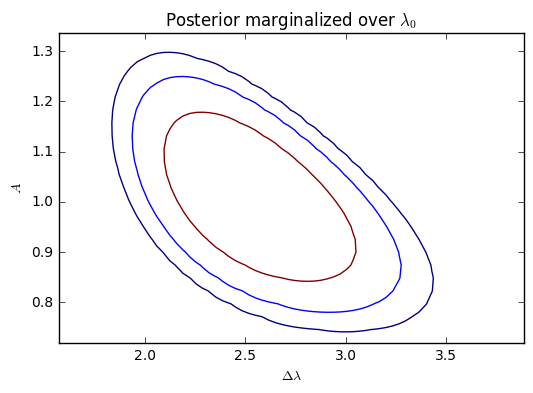

In [11]:
####
import scipy.integrate as intg

def ordered_line(l0,A,dl) : 
    return A*np.exp(-((l-l0)/dl)**2)

def ordered_likelihood(l0,A,dl) : 
    return np.exp(-0.5*np.sum(((f - ordered_line(l0,A,dl)- bmax)/s)**2))

def marginal(A,dl) : 
    return intg.quad(ordered_likelihood,10.,30.,args = (A,dl))[0]
    
da = maxpar[0]/40
a = np.arange(0.7*maxpar[0],1.3*maxpar[0],da)


ddl = maxpar[2]/80
deltal = np.arange(0.6*maxpar[2],1.5*maxpar[2],ddl)


like_marginalized_l0 = np.empty([len(a),len(deltal)])

for i in range(len(a)) : 
    for j in range(len(deltal)) : 
        like_marginalized_l0[i,j] = marginal(a[i],deltal[j])
        
post_marginalized_l0 = like_marginalized_l0/np.sum(like_marginalized_l0)/da

lev68 = find_level(post_mat,0.68)[0]
lev95 = find_level(post_mat,0.95)[0]
lev99 = find_level(post_mat,0.99)[0]

levels = (lev99, lev95, lev68)
        
X,Y = np.meshgrid(deltal,a)

plt.contour(X,Y,post_marginalized_l0, levels)
plt.xlabel('$\Delta\lambda$')
plt.ylabel('$A$')
plt.title('Posterior marginalized over $\lambda_0$')
plt.show()
    

7) Sum the 2D array from 6) to find the 1D marginalized posteriors for both 
$\Delta\lambda$ and $A$.

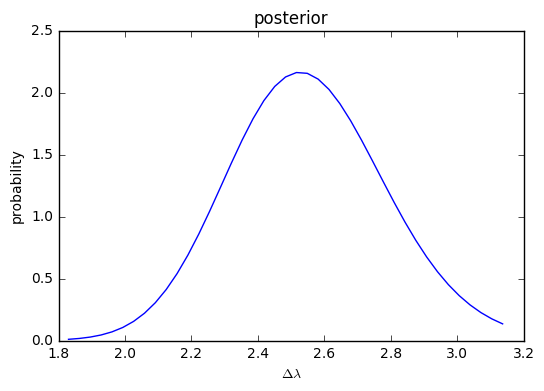

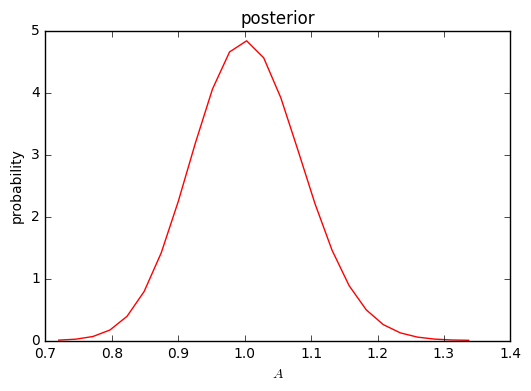

In [7]:
#####
deltal_posterior = np.sum(post_marginalized_l0, axis = 0)
plt.plot(deltal,deltal_posterior)
plt.xlabel('$\Delta\lambda$')
plt.ylabel('probability')
plt.title('posterior')
plt.show()
a_posterior = np.sum(post_marginalized_l0, axis = 1)
plt.xlabel('$A$')
plt.ylabel('probability')
plt.title('posterior')
plt.plot(a,a_posterior, color = 'red')
plt.show()

8) Do the same as 6) and 7) but for $A$ and $\lambda_o$ and marginalized over $\Delta\lambda$.                                                                                             

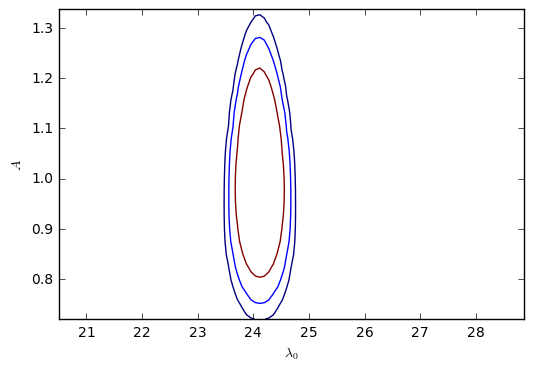

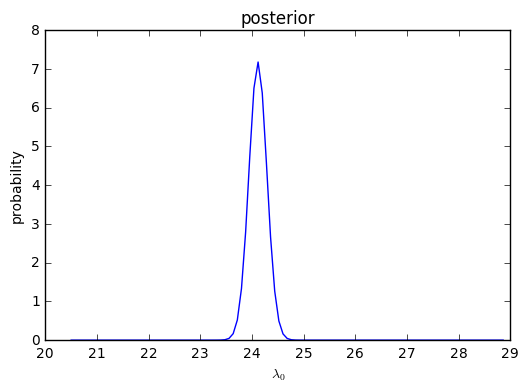

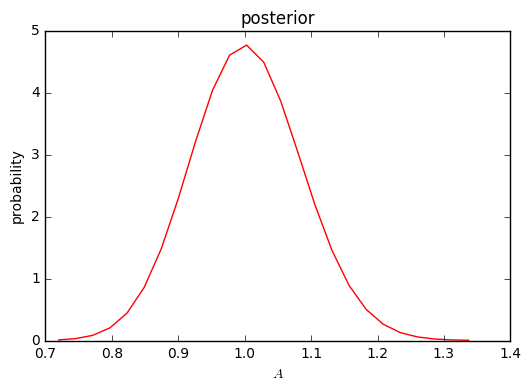

In [8]:
#####
def ordered_line2(dl,A,l0) : 
    return A*np.exp(-((l-l0)/dl)**2)

def ordered_likelihood2(dl,A,l0) : 
    return np.exp(-0.5*np.sum(((f - ordered_line2(dl,A,l0)- bmax)/s)**2))

def marginal2(A,l0) : 
    return intg.quad(ordered_likelihood2,1.,5.,args = (A,l0))[0]

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
da = maxpar[0]/40
a = np.arange(0.6*maxpar[0],1.5*maxpar[0],da)

dl0 = maxpar[1]/300
l0 = np.arange(0.85*maxpar[1],1.2*maxpar[1],dl0)

like_marginalized_dl = np.empty([len(a),len(l0)])

for i in range(len(a)) : 
    for j in range(len(l0)) : 
        like_marginalized_dl[i,j] = marginal2(a[i],l0[j])
        
post_marginalized_dl = like_marginalized_dl/np.sum(like_marginalized_dl)/da

lev68 = find_level(post_mat,0.68)[0]
lev95 = find_level(post_mat,0.95)[0]
lev99 = find_level(post_mat,0.99)[0]

levels = (lev99, lev95, lev68)
        
X,Y = np.meshgrid(l0,a)

plt.contour(X,Y,post_marginalized_dl, levels)
plt.xlabel('$\lambda_0$')
plt.ylabel('$A$')
plt.show()

l0_posterior = np.sum(post_marginalized_dl, axis = 0)
plt.plot(l0,l0_posterior)
plt.xlabel('$\lambda_0$')
plt.ylabel('probability')
plt.title('posterior')
plt.show()

a_posterior1 = np.sum(post_marginalized_dl, axis = 1)
plt.plot(a, a_posterior1, color = 'red')
plt.xlabel('$A$')
plt.ylabel('probability')
plt.title('posterior')
plt.show()



9) Do the same as 6) and 7) but for $\Delta\lambda$ and $\lambda_o$ and marginalized over $A$.

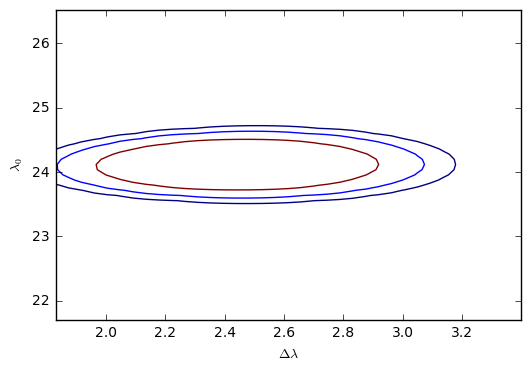

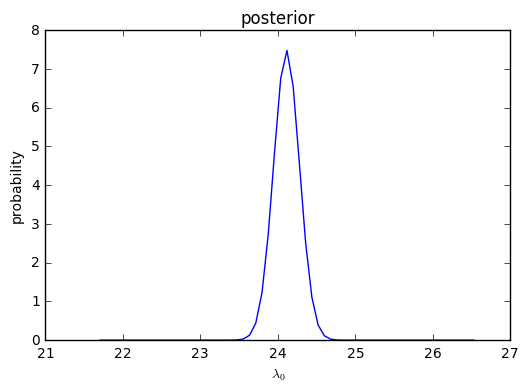

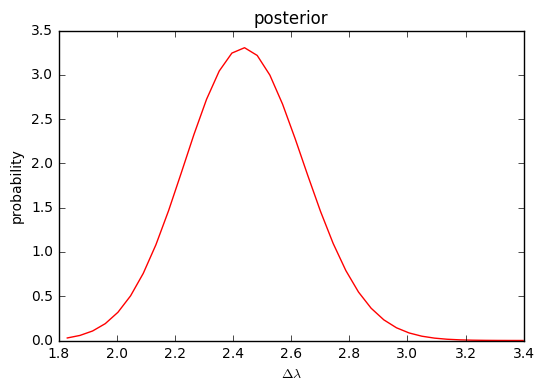

In [9]:
#####
def ordered_likelihood3(A,l0,dl) : 
    return np.exp(-0.5*np.sum(((f - line(A,l0,dl)- bmax)/s)**2))

def marginal3(l0,dl) : 
    return intg.quad(ordered_likelihood3,1.,5.,args = (l0,dl))[0]

dl0 = maxpar[1]/300
l0 = np.arange(0.9*maxpar[1],1.1*maxpar[1],dl0)

ddl = maxpar[2]/60
dl = np.arange(0.5*maxpar[2],1.3*maxpar[2],ddl)

like_marginalized_a = np.empty([len(l0),len(dl)])

for i in range(len(l0)) : 
    for j in range(len(dl)) : 
        like_marginalized_a[i,j] = marginal3(l0[i],dl[j])
        
post_marginalized_a = like_marginalized_a/np.sum(like_marginalized_a)/da

lev68 = find_level(post_mat,0.68)[0]
lev95 = find_level(post_mat,0.95)[0]
lev99 = find_level(post_mat,0.99)[0]

levels = (lev99, lev95, lev68)
        
X, Y = np.meshgrid(dl,l0)

plt.contour(X,Y,post_marginalized_a, levels)
plt.xlabel('$\Delta\lambda$')
plt.ylabel('$\lambda_0$')
plt.show()

l0_posterior = np.sum(post_marginalized_a, axis = 1)
plt.plot(l0, l0_posterior)
plt.xlabel('$\lambda_0$')
plt.ylabel('probability')
plt.title('posterior')
plt.show()

dl_posterior = np.sum(post_marginalized_a, axis = 0)
plt.plot(dl, dl_posterior, color = 'red')
plt.xlabel('$\Delta\lambda$')
plt.ylabel('probability')
plt.title('posterior')
plt.show()


10) Give the maximum likelihood estimate of each of the three parameters and 
their marginalized standard deviation. 

In [10]:
l0_maxlike = np.average(l0, weights = l0_posterior)
l0_stdev = np.std(l0)
print("The maximum likelihood estimate for lambda0 is %.2f. The marginalized standard deviation is %.2f" % (l0_maxlike, l0_stdev))


dl_maxlike = np.average(dl, weights = dl_posterior)
dl_stdev = np.std(dl)
print("The maximum likelihood estimate for Deltalambda is %.2f. The marginalized standard deviation is %.2f" % (dl_maxlike,dl_stdev))

a_maxlike = np.average(a, weights = a_posterior1)
a_stdev = np.std(a)
print("The maximum likelihood estimate for A is %.2f. The marginalized standard deviation is %.2f" % (a_maxlike, a_stdev))

#point 11 
#Calculate the evidence for the data without the line. Take λo and Δλ to be 
#fixed to their bast fit values. Calculate the evidence for the data with the line using a uniform prior for 
#A between 0 and 1. What is the odds for there being an emission line?

prior = 0.8
    
line_max = np.exp(-((l-maxpar[1])/maxpar[2])**2)
evidence_noline = np.exp(-0.5*np.sum((f-bmax)**2))
evidence_line = np.exp(-0.5*np.sum(f-prior*line_max-bmax)**2)
print('The evidence without the line is %.2f' % (evidence_noline))
print('The evidence with the line is %.2f' % (evidence_line))
bayes = evidence_noline/evidence_line
print('The Bayes factor is %.2f, so the model with the emission line must be the correct one.' % (bayes))



The maximum likelihood estimate for lambda0 is 24.11. The marginalized standard deviation is 1.42
The maximum likelihood estimate for Deltalambda is 2.44. The marginalized standard deviation is 0.47
The maximum likelihood estimate for A is 1.00. The marginalized standard deviation is 0.19
The evidence without the line is 0.23
The evidence with the line is 0.59
The Bayes factor is 0.39, so the model with the emission line must be the correct one.
